<a href="https://www.kaggle.com/code/samlinus/movierecommendationsystem?scriptVersionId=185325114" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Building Intuition

### About the Dataset

This dataset has more than 8000+ movies and Discover unparalleled cinematic excellence in this dataset (top_rated_movies1.csv) – a curated collection of IMDB's highest-rated films. Dive into a world of precision recommendations and elevate your movie experience with this treasure trove of acclaimed masterpieces

In [2]:
df = pd.read_csv(r'/kaggle/input/all-top-rated-imdb-movies-dataset/Top_rated_movies1.csv')
df

,id,title,overview,popularity,release_date,vote_average,vote_count
0,168705,BloodRayne,"In 18th-century Romania, after spending much o...",17.499,2005-10-22,4.105,501
1,19766,Inspector Gadget 2,"After capturing Claw, all the criminals have g...",20.772,2003-03-11,4.100,342
2,248705,The Visitors: Bastille Day,"Stuck in the corridors of time, Godefroy de Mo...",18.828,2016-03-23,4.090,636
3,17711,The Adventures of Rocky & Bullwinkle,Rocky and Bullwinkle have been living off the ...,16.436,2000-06-30,4.075,335
4,580,Jaws: The Revenge,"After another deadly shark attack, Ellen Brody...",30.996,1987-07-17,4.064,931
...,...,...,...,...,...,...,...
8826,12142,Alone in the Dark,Edward Carnby is a private investigator specia...,12.499,2005-01-28,3.228,550
8827,5491,Battlefield Earth,"In the year 3000, man is no match for the Psyc...",19.133,2000-05-12,3.221,761
8828,11059,House of the Dead,"Set on an island off the coast, a techno rave ...",10.795,2003-04-11,3.100,359
8829,14164,Dragonball Evolution,"On his 18th birthday, Goku receives a mystical...",38.646,2009-03-12,2.891,1925


In [3]:
df.describe()

,id,popularity,vote_average,vote_count
count,8.831000e+03,8831.000000,8831.000000,8831.000000
mean,1.775555e+05,33.136177,6.639059,1969.126486
std,2.352400e+05,49.108903,0.794924,3059.560533
min,5.000000e+00,0.600000,2.106000,1.000000
25%,9.927500e+03,16.729000,6.113500,469.000000
50%,3.387500e+04,23.804000,6.662000,846.000000
75%,3.345215e+05,35.751500,7.205000,1966.000000
max,1.151534e+06,1766.305000,8.708000,34794.000000


In [4]:
df.columns

Index(['id', 'title', 'overview', 'popularity', 'release_date', 'vote_average',
       'vote_count'],
      dtype='object')

In [5]:
df.isna().sum()

id              0
title           0
overview        1
popularity      0
release_date    0
vote_average    0
vote_count      0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8831 entries, 0 to 8830
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            8831 non-null   int64  
 1   title         8831 non-null   object 
 2   overview      8830 non-null   object 
 3   popularity    8831 non-null   float64
 4   release_date  8831 non-null   object 
 5   vote_average  8831 non-null   float64
 6   vote_count    8831 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 483.1+ KB


## Data Cleaning

Removing the row that has nan value

In [7]:
df.dropna(inplace=True)
df.shape

(8830, 7)

In [8]:
df.iloc[0].iloc[0]

168705

In [9]:
# Just trimming to avoid unwanted errors
# Movie titles are in the second column.
df['title'] = df['title'].str.strip()

## Data Manipulation

#### Manipulating rows with duplicate ids
1. Combining the duplicate rows (Rows with same movie id) by taking mean of the numerical values of the features.
2. Removing the duplicate rows from the existing dataframe.
3. Combining both

In [10]:
duplicate_df = df[df.duplicated('id', keep=False)]
final_df = df
unique_df = df.drop_duplicates('id', keep=False)
print(f'Length of duplicate rows: {len(duplicate_df)}, entire_df: {len(final_df)}, unique_df: {len(unique_df)}')
length_of_final_df = len(final_df) - len(duplicate_df)/2
print(f'Length of the combined df after aggregation should be: {length_of_final_df}')

Length of duplicate rows: 40, entire_df: 8830, unique_df: 8790
Length of the combined df after aggregation should be: 8810.0


In [11]:
# Group by 'id' and apply the consistency check
# Check consistency within each group for the specified features i.e., gives the count of unique values for the each features for each id..
consistency_check = duplicate_df.groupby('id')[['vote_count', 'vote_average', 'popularity']].nunique()
# Checks if all the values of the feature in each column is same
# consistency_check[~(consistency_check == 1).all(axis=1)]
consistent_groups = consistency_check[(consistency_check == 1).all(axis=1)] # unique ids (rows) with same vote_count and vote_average

num_consistent = len(consistent_groups)
num_inconsistent = len(duplicate_df)/2 - len(consistent_groups)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Consistency': ['Consistent', 'Inconsistent'],
    'Count': [num_consistent, num_inconsistent]
})

print("Summary of Consistent and Inconsistent Groups:")
print(summary_df)

# Plot the summary using Plotly
fig = px.bar(summary_df, x='Consistency', y='Count', title='Consistency of Duplicate Rows for Specific Features', 
             labels={'Count': 'Number of Groups', 'Consistency': 'Consistency Status'})

# Show plot
fig.show()

Summary of Consistent and Inconsistent Groups:
    Consistency  Count
0    Consistent    0.0
1  Inconsistent   20.0


- The above plot shows that duplicate rows with duplicate ids have different vote_count or vote_average or popularity value
- `Consistency` - By "consistency" in this context, we mean that for duplicate IDs, the values in the specified feature columns are the same across all duplicate rows.

#### Aggregating duplicate rows

In [12]:
# Taking mean as aggregate function
aggregated_df = duplicate_df.groupby('id').agg({
    'title': 'first',  # Keep the first title
    'overview': 'first',
    'release_date': 'first',
    'vote_count': 'mean',  # Take the mean of vote_count
    'vote_average': 'mean',  # Take the mean of vote_average
    'popularity': 'mean'  # Take the mean of popularity
}).reset_index()
final_df = pd.concat([unique_df, aggregated_df])

# Ensuring correctness 
print(f'Length of the combined df after aggregation should be: {length_of_final_df}')
print(f'After combining length of the combined df is : {len(final_df)}')
df = final_df

Length of the combined df after aggregation should be: 8810.0
After combining length of the combined df is : 8810


In [13]:
df['release_date'] = pd.to_datetime(df['release_date'])
df.dtypes

id                       int64
title                   object
overview                object
popularity             float64
release_date    datetime64[ns]
vote_average           float64
vote_count             float64
dtype: object

In [14]:
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month_name()
df['release_month_no'] = df['release_date'].dt.month

## Exploratory Data Analysis

**Before getting into EDA let's analyze what the columns are about,**
- id          : Unique movies id
- title       : Movies name
- overview    : Short summary of every movie
- popularity  : Popularity scale for every movies
- release_data: Date of movies released
- vote_average: Average vote scale for movies from 1 to 10
- vote_count  : Total vote count for each movies

Some movies may have same name.

In [15]:
print(f'No. of unique movie titles: {df["title"].nunique()}')

No. of unique movie titles: 8513


In [16]:
# Just cross checking
print(f'No. of unique movie ids: {df["id"].nunique()}')

No. of unique movie ids: 8810


**movie ids > movie titles**
- Therefore there is a possibility that same movie may be assigned with more than one movie ids.
- Meaning that there may be more than 1 movies with same name.

#### Movies with same names

In [17]:
# Grouping the movies with different ids - different movies with same name
title_id_counts = df.groupby('title')['id'].nunique()
same_titled_movies = title_id_counts[title_id_counts > 1].index.tolist()
print(f"Titles with multiple IDs: {len(same_titled_movies)}")

Titles with multiple IDs: 270


In [18]:
df[df['title']=='The Room']

,id,title,overview,popularity,release_date,vote_average,vote_count,release_year,release_month,release_month_no
8,17473,The Room,Johnny is a successful banker with great respe...,14.775,2003-06-27,4.035,1298.0,2003,June,6
5565,582913,The Room,Kate and Matt discover that a part of their ho...,20.959,2019-09-12,6.411,850.0,2019,September,9


In [19]:
# Marking the duplicate and unique rows for visualization..
df['title_type'] = df['title'].apply(lambda x: 'Duplicate' if x in same_titled_movies else 'Unique')
title_type_counts = df['title_type'].value_counts()

### Visualization

**Unique vs. Duplicate movie titles** 

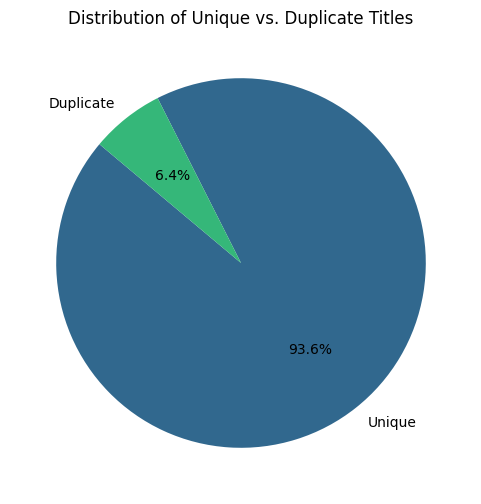

In [20]:
plt.figure(figsize=(6,6))
color = sns.color_palette('viridis', len(title_type_counts))
plt.pie(title_type_counts, labels=title_type_counts.index, autopct='%1.1f%%', colors= color, startangle=140)
plt.title('Distribution of Unique vs. Duplicate Titles')
plt.show()

#### Movies vs release date

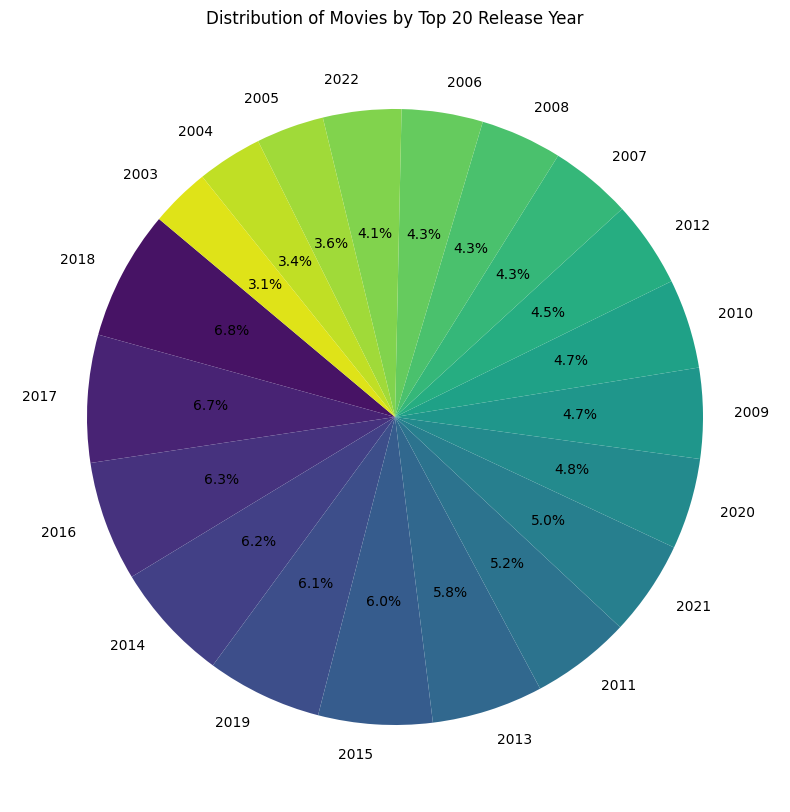

In [21]:
# Number of movies released each year 
release_year_counts = df['release_year'].value_counts()[:20]

# Plot the pie chart
plt.figure(figsize=(10, 10))
colors = sns.color_palette('viridis', len(release_year_counts))
plt.pie(release_year_counts, labels=release_year_counts.index, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Distribution of Movies by Top 20 Release Year')
plt.show()

#### Correlation between popularity, vote_average, vote_count, 

In [22]:
columns = ['popularity', 'vote_count', 'vote_average']
correlation_matrix = df[columns].corr()

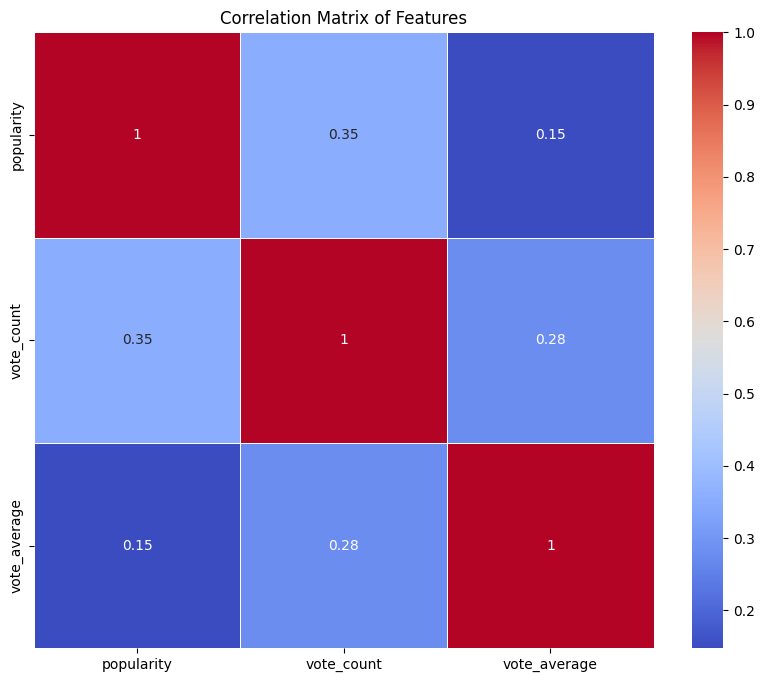

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

#### DISTRIBUTION OF POPULARITY

***Zoom the plot for better visualization***

In [24]:
fig = px.histogram(df['popularity'], x='popularity', title='Interactive Histogram of Popularity', color_discrete_sequence=['#1f77b4'])
fig.show()

#### DISTRIBUTION OF VOTE COUNT

In [25]:
fig = px.histogram(df['vote_count'], x='vote_count', title='Interactive Histogram of vote count', color_discrete_sequence=['#1f77b4'])
fig.show()

#### DISTRIBUTION OF VOTE AVERAGE

In [26]:
fig = px.histogram(df['vote_average'], x='vote_average', title='Interactive Histogram of Popularity', color_discrete_sequence=['#1f77b4'])
fig.show()

#### POPULARITY VS VOTE AVERAGE

In [27]:
fig = px.scatter_matrix(df, dimensions = ['popularity', 'vote_average'])
fig.show()

#### POULARITY VS VOTE COUNT

In [28]:
fig = px.scatter_matrix(df, dimensions = ['popularity', 'vote_count'])
fig.show()

#### VOTE VOUNT VS VOTE AVERAGE

In [29]:
fig = px.scatter_matrix(df, dimensions = ['vote_average', 'vote_count'])
fig.show()

#### Top 20 movies with most votes

In [30]:
def plot_top_20(feature: str, df: pd.DataFrame()):
    altered_df = df[['id','title',feature]].sort_values(by = feature, ascending=False).head(20)
    fig = px.bar(altered_df, x='title', y = feature, orientation='v', 
                 title=f'Top {20} Movies by {feature}', 
                 labels={'vote_count': feature.title(), 'title': 'Title'})
    fig.show()

In [31]:
plot_top_20('vote_count', df)

#### Top 20 popular movies

In [32]:
plot_top_20('popularity', df)

#### Top 20 movies with highest vote average

In [33]:
plot_top_20('vote_average', df)

## Time Series Analysis

### Trend over the years

In [34]:
# This function shows how the average feature has increased over the years..
def plot_timeseries_over_years(feature: str, df: pd.DataFrame):
    time_series_data = df.groupby('release_year').agg({feature: 'mean'}).reset_index()
    fig_popularity = px.line(time_series_data, x='release_year', y= feature, title=f'{feature.title()} Over the Years')
    fig_popularity.show()

In [35]:
time_series_features = ['popularity', 'vote_count', 'vote_average']
for feature in time_series_features:
    plot_timeseries_over_years(feature, df)

### Trend over months

In [36]:
def plot_timeseries_over_months(feature: str, df: pd.DataFrame):
    time_series_data = df.groupby('release_month').agg({feature: 'mean'}).reset_index()
    # Set the categorical order for the months to plot the curve in order...
    time_series_data['release_month'] = pd.Categorical(time_series_data['release_month'],
                                                   categories=['January', 'February', 'March', 'April', 'May', 'June', 
                                                               'July', 'August', 'September', 'October', 'November', 'December'],
                                                   ordered=True)
    # Sort the DataFrame by the categorical order
    time_series_data = time_series_data.sort_values('release_month')
    fig_popularity = px.line(time_series_data, x='release_month', y= feature, title=f'{feature.title()} Over the Months')
    fig_popularity.show()

In [37]:
df['release_month'].unique()

array(['October', 'March', 'June', 'July', 'February', 'August',
       'January', 'December', 'May', 'November', 'September', 'April'],
      dtype=object)

In [38]:
time_series_features = ['popularity', 'vote_count', 'vote_average']
for feature in time_series_features:
    plot_timeseries_over_months(feature, df)

## Building Recommendation System

> ### 1. Recommendation based on weighted rating
We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes

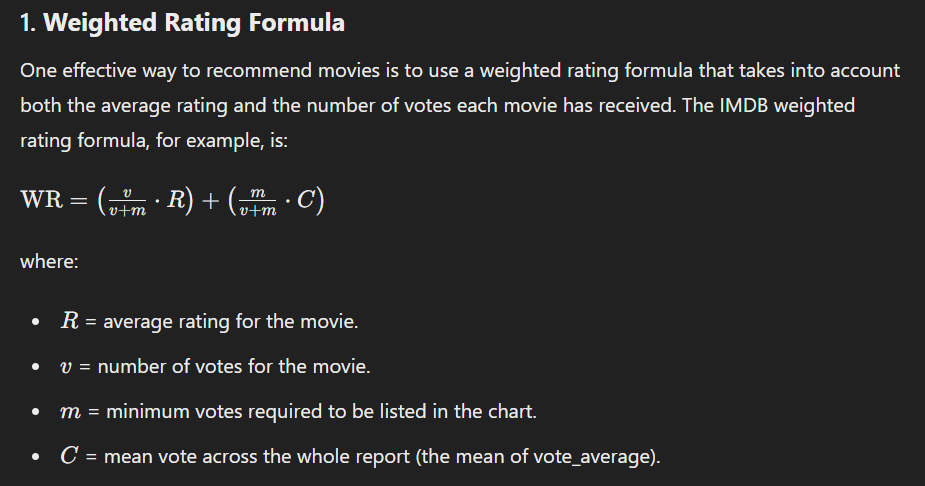
[***QUORA LINK***](https://www.kaggle.com/)

[**IMDB Top 250 Movies**](https://m.imdb.com/chart/top/)

In [39]:
def weighted_rating(df, m, C):
    v = df['vote_count']
    R = df['vote_average']
    return (v / (v+m) * R )+ (m / (m + v) * C)

# Calculate C (mean of vote_average)
C = df['vote_average'].mean()

# Define m (minimum votes required)
m = df['vote_count'].quantile(0.60)
# 60% of the datapoints exist with vote_count <=m 

# Filter movies that qualify for the chart
qualified_movies = df[df['vote_count'] >= m].copy()

# Calculate the weighted rating
qualified_movies['score'] = weighted_rating(qualified_movies, m, C)

# Sort movies based on score
recommended_movies = qualified_movies.sort_values('score', ascending=False)

print(recommended_movies[['title', 'score']])

                         title     score
121   The Shawshank Redemption  8.614463
120              The Godfather  8.590342
128            The Dark Knight  8.447121
123           Schindler's List  8.432368
122      The Godfather Part II  8.411954
...                        ...       ...
19              The Open House  5.080592
8808                Death Note  4.798954
8796            Batman & Robin  4.789835
8783            Fantastic Four  4.788865
8829      Dragonball Evolution  4.288819

[3525 rows x 2 columns]


> ### 2. Recommendation based on title and overview
The content-based recommendation system represents a widely adopted and robust approach within recommendation systems. This method is favored due to its reliance on static content, which remains consistent over time, unlike user preferences that are subject to change.

In [40]:
# Just extracting what we need alone from the dataframe..
df = df[['id','title', 'overview']]
df

,id,title,overview
0,168705,BloodRayne,"In 18th-century Romania, after spending much o..."
1,19766,Inspector Gadget 2,"After capturing Claw, all the criminals have g..."
2,248705,The Visitors: Bastille Day,"Stuck in the corridors of time, Godefroy de Mo..."
3,17711,The Adventures of Rocky & Bullwinkle,Rocky and Bullwinkle have been living off the ...
4,580,Jaws: The Revenge,"After another deadly shark attack, Ellen Brody..."
...,...,...,...
15,505642,Black Panther: Wakanda Forever,"Queen Ramonda, Shuri, M’Baku, Okoye and the Do..."
16,635910,The Last Voyage of the Demeter,The crew of the merchant ship Demeter attempts...
17,670292,The Creator,Amid a future war between the human race and t...
18,817758,TÁR,Renowned musician Lydia Tár is days away from ...


#### Text Preprocessing

Refer this notebook for basic preprocessing intuition - [ref notebook](https://www.kaggle.com/code/sudalairajkumar/getting-started-with-text-preprocessing)

In [41]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import string, nltk

In [42]:
# Kaggle is unable to unzip wordnet on its own so we are doing this manually
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [43]:
import re
stop_words = stopwords.words('english')
lemma = WordNetLemmatizer()
def preprocess(message: str):
    # Remove possessive suffixes
    message = re.sub(r"\b(\w+)'s\b", r'\1', message)
    message = re.sub(r"\b(\w+)s'\b", r'\1', message)
    
    words = message.lower()
    words = word_tokenize(words)
    words = ' '.join(process_words(words))
    return words
    

def process_words(words):
    res = []
    for word in words:
        if word not in string.punctuation \
        and len(word)>1 \
        and word not in stop_words: 
            lemma_word = lemma.lemmatize(word)
            if len(lemma_word) > 1:
                res.append(lemma_word)                
    
    return res

In [44]:
from tqdm.notebook import tqdm
tqdm.pandas(desc="Processing")
df['processed_overview'] = df['overview'].progress_apply(preprocess)
df

Processing:   0%|          | 0/8810 [00:00<?, ?it/s]

,id,title,overview,processed_overview
0,168705,BloodRayne,"In 18th-century Romania, after spending much o...",18th-century romania spending much life travel...
1,19766,Inspector Gadget 2,"After capturing Claw, all the criminals have g...",capturing claw criminal gone hiding claw escap...
2,248705,The Visitors: Bastille Day,"Stuck in the corridors of time, Godefroy de Mo...",stuck corridor time godefroy de montmirail fai...
3,17711,The Adventures of Rocky & Bullwinkle,Rocky and Bullwinkle have been living off the ...,rocky bullwinkle living finance made rerun car...
4,580,Jaws: The Revenge,"After another deadly shark attack, Ellen Brody...",another deadly shark attack ellen brody decide...
...,...,...,...,...
15,505642,Black Panther: Wakanda Forever,"Queen Ramonda, Shuri, M’Baku, Okoye and the Do...",queen ramonda shuri baku okoye dora milaje fig...
16,635910,The Last Voyage of the Demeter,The crew of the merchant ship Demeter attempts...,crew merchant ship demeter attempt survive oce...
17,670292,The Creator,Amid a future war between the human race and t...,amid future war human race force artificial in...
18,817758,TÁR,Renowned musician Lydia Tár is days away from ...,renowned musician lydia tár day away recording...


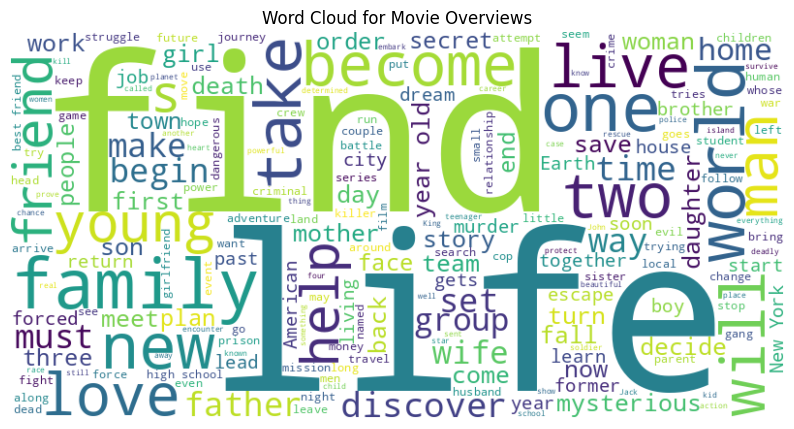

In [45]:
from wordcloud import WordCloud
text = ' '.join(df['overview'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Movie Overviews')
plt.axis('off')
plt.show()

***After Preprocessing...***

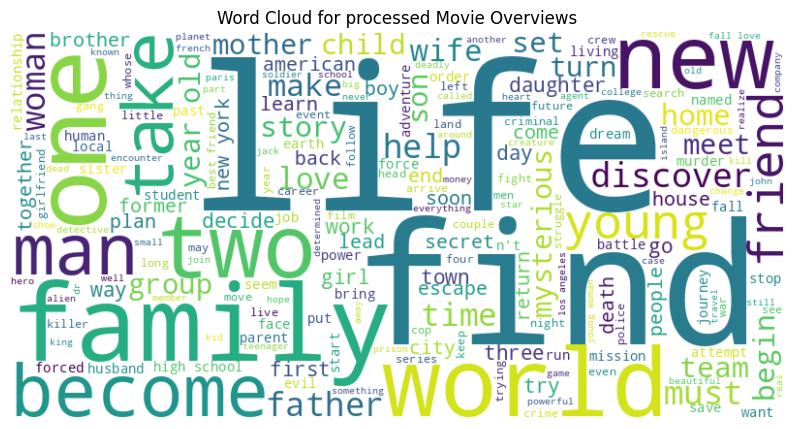

In [46]:
from wordcloud import WordCloud
text = ' '.join(df['processed_overview'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for processed Movie Overviews')
plt.axis('off')
plt.show()

In [47]:
# Checking for NAN values...
df['processed_overview'].isna().sum()

0

Combining both the `title` and `overview` of movies to create a richer feature set can indeed improve the quality of clustering. By using both the title and the overview, you provide the model with more context, which can lead to better differentiation between clusters.

**Content based filtering is done using 3 different approaches:**
1. jaccard similarity
2. TFIDF - cosine similarity
3. Count Vectorizer - cosine similarity

In [48]:
# Combining both title and overview
df['text'] = df['title'].str.lower() + ' ' + df['processed_overview']
df = df.reset_index(drop=True)

>#### JACCARD SIMILARITY

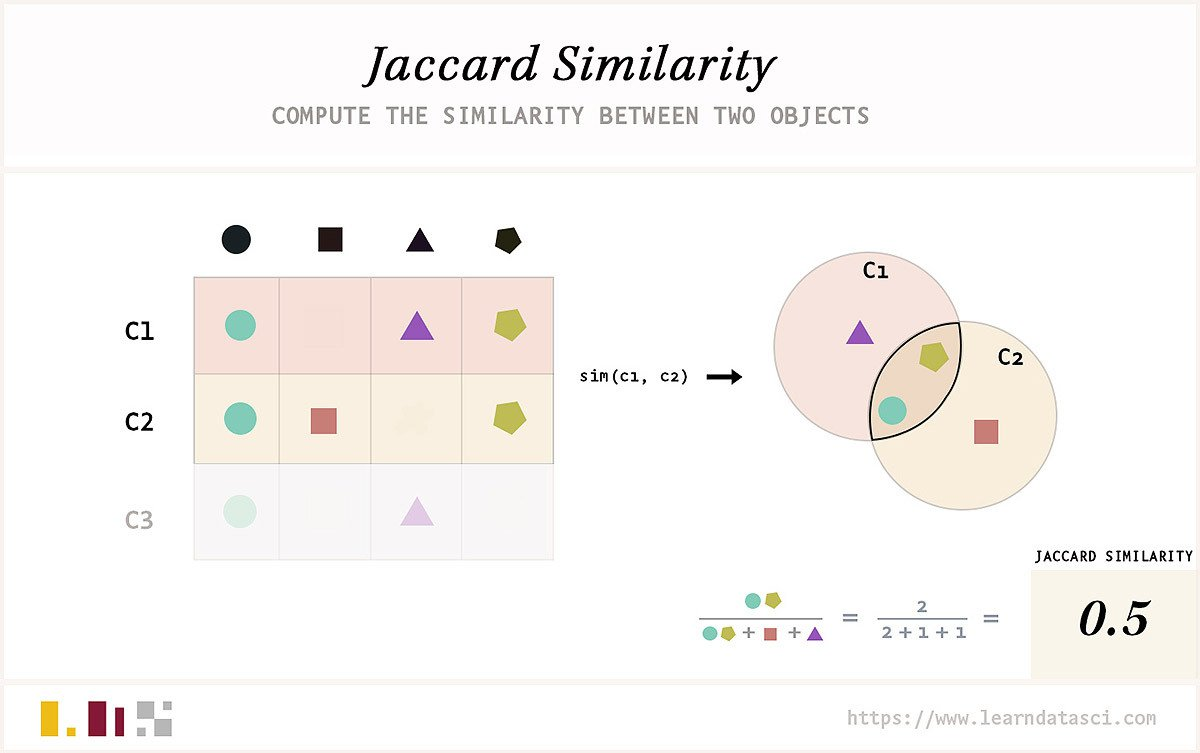

> Step 1: Create encoding for unique words in the whole corpus.

> Step 2: Replace the encodings on each row's `text` .

> Step 3: Using the encoding vectors find the jaccard similarity.

> Step 4: Recommend movies top scores.

In [49]:
df

,id,title,overview,processed_overview,text
0,168705,BloodRayne,"In 18th-century Romania, after spending much o...",18th-century romania spending much life travel...,bloodrayne 18th-century romania spending much ...
1,19766,Inspector Gadget 2,"After capturing Claw, all the criminals have g...",capturing claw criminal gone hiding claw escap...,inspector gadget 2 capturing claw criminal gon...
2,248705,The Visitors: Bastille Day,"Stuck in the corridors of time, Godefroy de Mo...",stuck corridor time godefroy de montmirail fai...,the visitors: bastille day stuck corridor time...
3,17711,The Adventures of Rocky & Bullwinkle,Rocky and Bullwinkle have been living off the ...,rocky bullwinkle living finance made rerun car...,the adventures of rocky & bullwinkle rocky bul...
4,580,Jaws: The Revenge,"After another deadly shark attack, Ellen Brody...",another deadly shark attack ellen brody decide...,jaws: the revenge another deadly shark attack ...
...,...,...,...,...,...
8805,505642,Black Panther: Wakanda Forever,"Queen Ramonda, Shuri, M’Baku, Okoye and the Do...",queen ramonda shuri baku okoye dora milaje fig...,black panther: wakanda forever queen ramonda s...
8806,635910,The Last Voyage of the Demeter,The crew of the merchant ship Demeter attempts...,crew merchant ship demeter attempt survive oce...,the last voyage of the demeter crew merchant s...
8807,670292,The Creator,Amid a future war between the human race and t...,amid future war human race force artificial in...,the creator amid future war human race force a...
8808,817758,TÁR,Renowned musician Lydia Tár is days away from ...,renowned musician lydia tár day away recording...,tár renowned musician lydia tár day away recor...


Generating tokens

In [50]:
# Step 1
text = ' '.join(df['text'])
# Tokenize the concatenated string to extract unique words
tokens = word_tokenize(text)  # Tokenize and convert to lowercase
# Get unique words
unique_words = set(tokens)

print(f'Total tokens: {len(tokens)}, unique tokens: {len(unique_words)}')

Total tokens: 259368, unique tokens: 28355


Encoding...

In [51]:
encoding_dict = {token: i for i,token in enumerate(unique_words)}
list(encoding_dict.items())[:5]

[('elementary', 0),
 ('robotnik', 1),
 ('revive', 2),
 ('h.i.v.e', 3),
 ('romanoff', 4)]

Generating encoding vector...

In [52]:
def encode_row(row):
    overview = row['text']
    tokens = word_tokenize(overview)
    encoded_tokens = [encoding_dict[token] for token in tokens]
    return encoded_tokens

# Apply encoding to each row
tqdm.pandas(desc="Encoding")
df['encoded_tokens'] = df.progress_apply(encode_row, axis=1)

Encoding:   0%|          | 0/8810 [00:00<?, ?it/s]

In [53]:
df[['text', 'encoded_tokens']]

,text,encoded_tokens
0,bloodrayne 18th-century romania spending much ...,"[10351, 20574, 27766, 4541, 25968, 4304, 24758..."
1,inspector gadget 2 capturing claw criminal gon...,"[16948, 8061, 25074, 18084, 22918, 7255, 1632,..."
2,the visitors: bastille day stuck corridor time...,"[19487, 22558, 8041, 21435, 18524, 20636, 2229..."
3,the adventures of rocky & bullwinkle rocky bul...,"[19487, 21145, 10011, 9306, 4622, 27944, 9306,..."
4,jaws: the revenge another deadly shark attack ...,"[17492, 8041, 19487, 10226, 26717, 24100, 2533..."
...,...,...
8805,black panther: wakanda forever queen ramonda s...,"[15847, 10598, 8041, 21503, 10357, 972, 23784,..."
8806,the last voyage of the demeter crew merchant s...,"[19487, 1760, 11613, 10011, 19487, 5891, 4359,..."
8807,the creator amid future war human race force a...,"[19487, 10789, 18009, 9832, 7966, 6819, 1387, ..."
8808,tár renowned musician lydia tár day away recor...,"[1177, 4576, 5327, 15457, 1177, 18524, 4284, 1..."


In [54]:
df.columns

Index(['id', 'title', 'overview', 'processed_overview', 'text',
       'encoded_tokens'],
      dtype='object')

Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [55]:
df['unique_key'] = df['title'].str.lower() + '_' + df.index.astype(str)
indices = pd.Series(df.index, index=df['unique_key'])
len(indices)

8810

In [56]:
df

,id,title,overview,processed_overview,text,encoded_tokens,unique_key
0,168705,BloodRayne,"In 18th-century Romania, after spending much o...",18th-century romania spending much life travel...,bloodrayne 18th-century romania spending much ...,"[10351, 20574, 27766, 4541, 25968, 4304, 24758...",bloodrayne_0
1,19766,Inspector Gadget 2,"After capturing Claw, all the criminals have g...",capturing claw criminal gone hiding claw escap...,inspector gadget 2 capturing claw criminal gon...,"[16948, 8061, 25074, 18084, 22918, 7255, 1632,...",inspector gadget 2_1
2,248705,The Visitors: Bastille Day,"Stuck in the corridors of time, Godefroy de Mo...",stuck corridor time godefroy de montmirail fai...,the visitors: bastille day stuck corridor time...,"[19487, 22558, 8041, 21435, 18524, 20636, 2229...",the visitors: bastille day_2
3,17711,The Adventures of Rocky & Bullwinkle,Rocky and Bullwinkle have been living off the ...,rocky bullwinkle living finance made rerun car...,the adventures of rocky & bullwinkle rocky bul...,"[19487, 21145, 10011, 9306, 4622, 27944, 9306,...",the adventures of rocky & bullwinkle_3
4,580,Jaws: The Revenge,"After another deadly shark attack, Ellen Brody...",another deadly shark attack ellen brody decide...,jaws: the revenge another deadly shark attack ...,"[17492, 8041, 19487, 10226, 26717, 24100, 2533...",jaws: the revenge_4
...,...,...,...,...,...,...,...
8805,505642,Black Panther: Wakanda Forever,"Queen Ramonda, Shuri, M’Baku, Okoye and the Do...",queen ramonda shuri baku okoye dora milaje fig...,black panther: wakanda forever queen ramonda s...,"[15847, 10598, 8041, 21503, 10357, 972, 23784,...",black panther: wakanda forever_8805
8806,635910,The Last Voyage of the Demeter,The crew of the merchant ship Demeter attempts...,crew merchant ship demeter attempt survive oce...,the last voyage of the demeter crew merchant s...,"[19487, 1760, 11613, 10011, 19487, 5891, 4359,...",the last voyage of the demeter_8806
8807,670292,The Creator,Amid a future war between the human race and t...,amid future war human race force artificial in...,the creator amid future war human race force a...,"[19487, 10789, 18009, 9832, 7966, 6819, 1387, ...",the creator_8807
8808,817758,TÁR,Renowned musician Lydia Tár is days away from ...,renowned musician lydia tár day away recording...,tár renowned musician lydia tár day away recor...,"[1177, 4576, 5327, 15457, 1177, 18524, 4284, 1...",tár_8808


Dictionary that contains unique movie titles + index as keys and movie corressponding titles as values, since there are more than 1 movie with same titles...

In [57]:
# Create a dictionary mapping unique keys to titles
unique_key_to_title = {unique_key: title for unique_key, title in zip(df['unique_key'], df['title'])}
list(unique_key_to_title.items())[:5]

[('bloodrayne_0', 'BloodRayne'),
 ('inspector gadget 2_1', 'Inspector Gadget 2'),
 ('the visitors: bastille day_2', 'The Visitors: Bastille Day'),
 ('the adventures of rocky & bullwinkle_3',
  'The Adventures of Rocky & Bullwinkle'),
 ('jaws: the revenge_4', 'Jaws: The Revenge')]

In [58]:
df.columns

Index(['id', 'title', 'overview', 'processed_overview', 'text',
       'encoded_tokens', 'unique_key'],
      dtype='object')

These are the following steps :-
- Get the index of the movie title.
- Get the similarity scores between the vector encodings of other movies.
- Sort the movies with high similar scores in descending
- Slice 10 from them.
- Now conver the unique movie titles to movie titles.

In [59]:
def get_jaccard_recommendations(title: str, df: pd.DataFrame, indices: [], key_to_title: dict):
    # Get the index of the movie that matches the title
    idx = indices[title]
    sim_scores = get_similarity_scores(idx, df)
    # Sort scores in descending order based on similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[:10]
    # Get indices of top 10 similar movies
    top_indices = [x[0] for x in sim_scores]
    # Getting the unique titles
    unique_titles = df['unique_key'].iloc[top_indices].tolist()
    # Return titles of top 10 similar movies
    movie_titles =  [key_to_title[title] for title in unique_titles]
    movie_scores = [x[1] for x in sim_scores]
    data = {
        'title': movie_titles,
        'score': movie_scores
    }
    return pd.DataFrame(data)
    

In [60]:
# Calculate scores with all other movies
def get_similarity_scores(index: int, df: pd.DataFrame):
    similarity_matrix = []
    for i in range(len(df)):
        if i!=index:
            sim_score = calculate_jaccard_simlarity(set(df.iloc[index].iloc[5]), set(df.iloc[i].iloc[5]))
            similarity_matrix.append((i, sim_score))
    
    return similarity_matrix

In [61]:
def calculate_jaccard_simlarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0  # Handle case where union is 0

> #### Prediction

Checking the indices..

In [62]:
df[df['title']=='The Dark Knight']

,id,title,overview,processed_overview,text,encoded_tokens,unique_key
127,155,The Dark Knight,Batman raises the stakes in his war on crime. ...,batman raise stake war crime help lt. jim gord...,the dark knight batman raise stake war crime h...,"[19487, 27970, 7163, 28286, 9014, 18425, 7966,...",the dark knight_127


In [63]:
indices['the dark knight_127']

127

In [64]:
movie_title = 'the dark knight_127'
recommendations = get_jaccard_recommendations(movie_title, df, indices, unique_key_to_title)
print(f"Top 10 movies similar to '{movie_title}':")
print(recommendations)

Top 10 movies similar to 'the dark knight_127':
                                     title     score
0     Batman: The Long Halloween, Part One  0.156250
1                    The Dark Knight Rises  0.144928
2     Batman: The Long Halloween, Part Two  0.135593
3             Batman: Mask of the Phantasm  0.113208
4  Batman: The Dark Knight Returns, Part 1  0.112903
5                In Order of Disappearance  0.098592
6                               The Batman  0.098039
7                   This Must Be the Place  0.096154
8                 Batman: The Killing Joke  0.092593
9                         Reasonable Doubt  0.086957


Let's look at the overviews of the movies..

In [65]:
df[df['title']=='The Dark Knight'].iloc[0,4]

'the dark knight batman raise stake war crime help lt. jim gordon district attorney harvey dent batman set dismantle remaining criminal organization plague street partnership prof effective soon find prey reign chaos unleashed rising criminal mastermind known terrified citizen gotham joker'

In [66]:
df[df['title']=='Batman: The Long Halloween, Part One'].iloc[0,4]

'batman: the long halloween, part one following brutal series murder taking place halloween thanksgiving christmas gotham city young vigilante known batman set pursue mysterious serial killer alongside police officer james gordon district attorney harvey dent'

Common tokens between the top similar movie

In [67]:
set(df[df['title']=='The Dark Knight'].iloc[0,4].split(' ')).intersection(df[df['title']=='Batman: The Long Halloween, Part One'].iloc[0,4].split(' '))

{'attorney',
 'batman',
 'dent',
 'district',
 'gordon',
 'gotham',
 'harvey',
 'known',
 'set',
 'the'}

> #### COSINE SIMILARITY
We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:

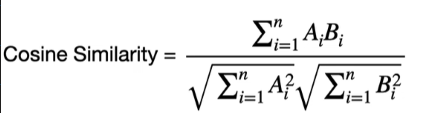

#### Using TFIDF

In [68]:
#Import TfIdfVectorizer from scikit-learn

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

df['processed_text'] = df['text'].fillna('')

# Step 1: Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['processed_text'])

#Output the shape of tfidf_matrix
print(f'TFIDF matrix shape: {tfidf_matrix.shape}')

# Step 2: Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

TFIDF matrix shape: (8810, 25097)


We see that over 25,000 different words were used to describe the 4800 movies in our dataset.

***Note***
- Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score.
- Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

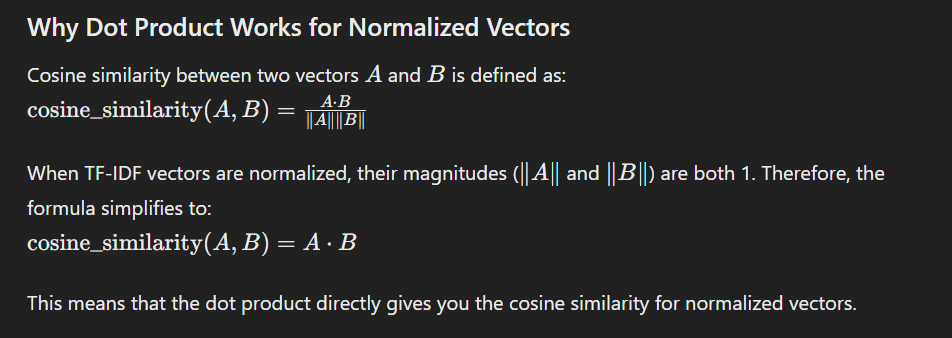

In [69]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim, df: pd.DataFrame, indices):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [70]:
movie_title = 'the dark knight_127'
recommendations = get_recommendations(movie_title, cosine_sim = cosine_sim, df = df, indices = indices)
print(f"Top 10 movies similar to '{movie_title}':")
print(recommendations)

Top 10 movies similar to 'the dark knight_127':
1484       Batman: The Long Halloween, Part Two
1353       Batman: The Long Halloween, Part One
713                       The Dark Knight Rises
2277                                     Batman
483     Batman: The Dark Knight Returns, Part 2
1338               Batman: Mask of the Phantasm
792     Batman: The Dark Knight Returns, Part 1
4728                   Batman: The Killing Joke
4444                 Batman: Gotham by Gaslight
854                                  The Batman
Name: title, dtype: object


#### Using Countvectorizer

In [71]:
count_vectorizer = CountVectorizer()

# Fit and transform the text data
count_matrix = count_vectorizer.fit_transform(df['processed_text'])

# Compute cosine similarity on the count_matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [72]:
movie_title = 'the dark knight_127'
recommendations = get_recommendations(movie_title, cosine_sim = cosine_sim, df = df, indices = indices)
print(f"Top 10 movies similar to '{movie_title}':")
print(recommendations)

Top 10 movies similar to 'the dark knight_127':
713                       The Dark Knight Rises
1484       Batman: The Long Halloween, Part Two
1338               Batman: Mask of the Phantasm
1353       Batman: The Long Halloween, Part One
2277                                     Batman
792     Batman: The Dark Knight Returns, Part 1
854                                  The Batman
483     Batman: The Dark Knight Returns, Part 2
4728                   Batman: The Killing Joke
4444                 Batman: Gotham by Gaslight
Name: title, dtype: object


## Conclusion
> The movie recommendation system leverages weighted ratings and cosine similarity, combined with extensive exploratory data analysis (EDA) and multiple approaches, to accurately recommend films. By addressing title duplicates and ensuring unique identifiers, the system effectively matches user preferences with similar movies, enhancing the overall recommendation accuracy and user satisfaction

### References Notebooks
> 1. [Building recommendation system](https://www.kaggle.com/code/samlinus/moviermdsystem-2/edit/run/184914068)
> 2. [EDA](https://www.kaggle.com/code/prajwaldongre/eda-on-top-rated-imdb-movies/notebook)

### Enhancements
> 1. Try applying KMeans - It seems to take much time.
> 2. Try implementing dimensionality reduction techniques too.

***THANK YOU***